<a href="https://colab.research.google.com/github/brianhumphreys/Moire-Detector/blob/main/Copy_of_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Playground

## Test 2D Wavelet Decomposition function
This function(fwdHaarDWT2D) computes the 2D Wavelet Transform in the image. All the input images are passed through a Haar Wavelet Decomposition module, to get the LL, LH, HL and HHH component of the image.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/")
!ls

os.chdir("../..")
!ls

MyDrive
bin	 datalab  home	 lib64	opt   run   sys		       tools
boot	 dev	  lib	 media	proc  sbin  tensorflow-1.15.2  usr
content  etc	  lib32  mnt	root  srv   tmp		       var


In [29]:
!ls

bin	    etc    moirePattern3CNN_.h5  sys		    trainDataPositive
boot	    home   opt			 tensorflow-1.15.2  usr
checkPoint  lib    proc			 testDataNegative   var
chl.jpg     lib32  root			 testDataPositive
content     lib64  run			 tmp
datalab     media  sbin			 tools
dev	    mnt    srv			 trainDataNegative


In [4]:
#This function(fwdHaarDWT2D) computes the 2D Wavelet Transform in the image. All the input images are passed through a Haar Wavelet Decomposition module, to get the LL, LH, HL and HHH component of the image

import numpy as np
import pywt

def splitFreqBands(img, levRows, levCols):
    halfRow = int(levRows/2)
    halfCol = int(levCols/2)
    LL = img[0:halfRow, 0:halfCol]
    LH = img[0:halfRow, halfCol:levCols]
    HL = img[halfRow:levRows, 0:halfCol]
    HH = img[halfRow:levRows, halfCol:levCols]
    
    return LL, LH, HL, HH
    
def haarDWT1D(data, length):
    avg0 = 0.5;
    avg1 = 0.5;
    dif0 = 0.5;
    dif1 = -0.5;
    temp = np.empty_like(data)
    temp = temp.astype(float)
    h = int(length/2)
    for i in range(h):
        k = i*2
        temp[i] = data[k] * avg0 + data[k + 1] * avg1;
        temp[i + h] = data[k] * dif0 + data[k + 1] * dif1;
    
    data[:] = temp

# computes the homography coefficients for PIL.Image.transform using point correspondences
def fwdHaarDWT2D(img):
    img = np.array(img)
    levRows = img.shape[0];
    levCols = img.shape[1];
    img = img.astype(float)
    for i in range(levRows):
        row = img[i,:]
        haarDWT1D(row, levCols)
        img[i,:] = row
    for j in range(levCols):
        col = img[:,j]
        haarDWT1D(col, levRows)
        img[:,j] = col
        
    return splitFreqBands(img, levRows, levCols)

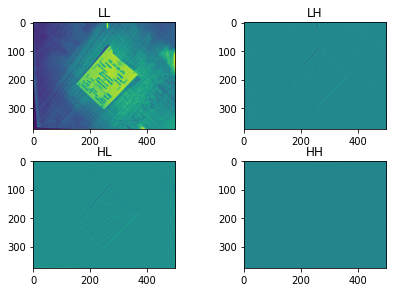

In [5]:
from PIL import Image
from matplotlib import pyplot as plt

img = Image.open('/content/drive/MyDrive/Moire/positiveImages/350_letterbox1024.jpg').convert('L')
img = img.transpose(Image.FLIP_LEFT_RIGHT)
img.save('chl.jpg')
LL, LH, HL, HH = fwdHaarDWT2D(img)
fig, axes = plt.subplots(2, 2)
fig.tight_layout()
axes[0, 0].imshow(LL)
axes[0, 1].imshow(LH)
axes[1, 0].imshow(HL)
axes[1, 1].imshow(HH)
axes[0, 0].set_title("LL")
axes[0, 1].set_title("LH")
axes[1, 0].set_title("HL")
axes[1, 1].set_title("HH")
plt.show()

## Test training data creation
The training images need to be put in two folders. positiveImages and negativeImages. positiveImages are the images which are captured from the display devices and has the presence of stron or weak Moiré patterms in it.
negativeImages are the ones without Moiré Patterns (i.e. the images which are not captured from the display devices) 

In [37]:
import sys
import argparse
from PIL import Image
from PIL import ImageOps
import random
import sys
import os

from os import listdir
from os.path import isfile, join
from PIL import Image

#The training images need to be put in two folders. positiveImages and negativeImages. positiveImages are the images which are captured from the display devices and has the presence of stron or weak Moiré patterms in it. negativeImages are the ones without Moiré Patterns (i.e. the images which are not captured from the display devices)


#folders to store training data
positiveTrainImagePath = ''
negativeTrainImagePath = ''

def mainAugment(positiveImages, negativeImages, train):
    
    global positiveTrainImagePath
    global negativeTrainImagePath
    
    positiveImagePath = (positiveImages)
    negativeImagePath = (negativeImages)
    
    if (train == 0):
        positiveTrainImagePath = './trainDataPositive'
        negativeTrainImagePath = './trainDataNegative'
    else:
        positiveTrainImagePath = './testDataPositive'
        negativeTrainImagePath = './testDataNegative'
        
    createTrainingData(positiveImagePath, negativeImagePath)

    
#The wavelet decomposed images are the transformed images representing the spatial and the frequency information of the image. These images are stored as 'tiff' in the disk, to preserve that information. Each image is transformed with 180 degrees rotation and as well flipped, as part of data augmentation.

def transformImageAndSave(image, f, customStr, path):
    cA, cH, cV, cD  = fwdHaarDWT2D(image);

    # fig, axes = plt.subplots(2, 2)
    # fig.tight_layout()
    # axes[0, 0].imshow(cA)
    # axes[0, 1].imshow(cH)
    # axes[1, 0].imshow(cV)
    # axes[1, 1].imshow(cD)
    # axes[0, 0].set_title("LL")
    # axes[0, 1].set_title("LH")
    # axes[1, 0].set_title("HL")
    # axes[1, 1].set_title("HH")
    # plt.show()
    
    fileName = (os.path.splitext(f)[0])
    fLL = (f.replace(fileName, fileName+'_' + customStr + 'LL')).replace('.jpg','.tiff')
    fLH = (f.replace(fileName, fileName+'_' + customStr + 'LH')).replace('.jpg','.tiff')
    fHL = (f.replace(fileName, fileName+'_' + customStr + 'HL')).replace('.jpg','.tiff')
    fHH = (f.replace(fileName, fileName+'_' + customStr + 'HH')).replace('.jpg','.tiff')
    cA = Image.fromarray(cA)
    cH = Image.fromarray(cH)
    cV = Image.fromarray(cV)
    cD = Image.fromarray(cD)
    cA.save(join(path, fLL))
    cH.save(join(path, fLH))
    cV.save(join(path, fHL))
    cD.save(join(path, fHH))
    
    
def augmentAndTrasformImage(f, mainFolder, trainFolder):
    try:
        img = Image.open(join(mainFolder, f)) 
    except:
        print('Error: Couldnt read the file {}. Make sure only images are present in the folder'.format(f))
        return None

    imgGray = img.convert('L')
    wdChk, htChk = imgGray.size
    if htChk > wdChk:
        imgGray = imgGray.rotate(-90, expand=1)
        print('training image rotated')
    transformImageAndSave(imgGray, f, '', trainFolder)

    imgGray = imgGray.transpose(Image.ROTATE_180)
    transformImageAndSave(imgGray, f, '180_', trainFolder)

    imgGray = imgGray.transpose(Image.FLIP_LEFT_RIGHT)
    transformImageAndSave(imgGray, f, '180_FLIP_', trainFolder)
    
    return True
    
    
def createTrainingData(positiveImagePath, negativeImagePath):
    
    # get image files by classes
    positiveImageFiles = [f for f in listdir(positiveImagePath) if (isfile(join(positiveImagePath, f)))]
    negativeImageFiles = [f for f in listdir(negativeImagePath) if (isfile(join(negativeImagePath, f)))]

    positiveCount = len(positiveImageFiles)
    negativeCount = len(negativeImageFiles)

    print('positive samples: ' + str(positiveCount))
    print('negative samples: ' + str(negativeCount))
    
    # create folders (not tracked by git)
    if not os.path.exists(positiveTrainImagePath):
        os.makedirs(positiveTrainImagePath)
    if not os.path.exists(negativeTrainImagePath):
        os.makedirs(negativeTrainImagePath)

    Knegative = 0
    Kpositive = 0

    # create positive training images 
    for f in positiveImageFiles:
        ret = augmentAndTrasformImage(f, positiveImagePath, positiveTrainImagePath)
        if ret == None:
            continue
        Kpositive += 3


    # create negative training images 
    for f in negativeImageFiles:
        ret = augmentAndTrasformImage(f, negativeImagePath, negativeTrainImagePath)
        if ret == None:
            continue
        Knegative += 3;
    
    print('Total positive files after augmentation: ', Kpositive)
    print('Total negative files after augmentation: ', Knegative)
    
        

def parse_arguments(argv):
    parser = argparse.ArgumentParser()
    
    parser.add_argument('positiveImages', type=str, help='Directory with positive (Moiré pattern) images.')
    parser.add_argument('negativeImages', type=str, help='Directory with negative (Normal) images.')
    parser.add_argument('train', type=int, help='0 = train, 1 = test')
    
    return parser.parse_args(argv)

In [38]:
from os import listdir
from os.path import isfile, join
from PIL import Image


positiveImagePath = '/content/drive/MyDrive/Moire/positiveImages'
negativeImagePath = '/content/drive/MyDrive/Moire/negativeImages'

mainAugment(positiveImagePath, negativeImagePath, 0)
   

positive samples: 4
negative samples: 4
training image rotated
training image rotated
training image rotated
Total positive files after augmentation:  12
Total negative files after augmentation:  12


In [36]:
!ls trainDataNegative/

0_letterbox1024_180_FLIP_HH.tiff   22_letterbox1024_180_FLIP_HH.tiff
0_letterbox1024_180_FLIP_HL.tiff   22_letterbox1024_180_FLIP_HL.tiff
0_letterbox1024_180_FLIP_LH.tiff   22_letterbox1024_180_FLIP_LH.tiff
0_letterbox1024_180_FLIP_LL.tiff   22_letterbox1024_180_FLIP_LL.tiff
0_letterbox1024_180_HH.tiff	   22_letterbox1024_180_HH.tiff
0_letterbox1024_180_HL.tiff	   22_letterbox1024_180_HL.tiff
0_letterbox1024_180_LH.tiff	   22_letterbox1024_180_LH.tiff
0_letterbox1024_180_LL.tiff	   22_letterbox1024_180_LL.tiff
0_letterbox1024_HH.tiff		   22_letterbox1024_HH.tiff
0_letterbox1024_HL.tiff		   22_letterbox1024_HL.tiff
0_letterbox1024_LH.tiff		   22_letterbox1024_LH.tiff
0_letterbox1024_LL.tiff		   22_letterbox1024_LL.tiff
14_letterbox1024_180_FLIP_HH.tiff  37_letterbox1024_180_FLIP_HH.tiff
14_letterbox1024_180_FLIP_HL.tiff  37_letterbox1024_180_FLIP_HL.tiff
14_letterbox1024_180_FLIP_LH.tiff  37_letterbox1024_180_FLIP_LH.tiff
14_letterbox1024_180_FLIP_LL.tiff  37_letterbox1024_180_FLIP_LL.t

## Test CNN training

In [39]:
import os

from keras.models import Model # basic class for specifying and training a neural network
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Add, Multiply, Maximum

def createModel(height, width, depth, num_classes):
#     num_epochs = 20 # 50 26 200 # we iterate 200 times over the entire training set
    kernel_size_1 = 7 # we will use 7x7 kernels 
    kernel_size_2 = 3 # we will use 3x3 kernels 
    pool_size = 2 # we will use 2x2 pooling throughout
    conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
    conv_depth_2 = 16 # ...switching to 16 after the first pooling layer
    drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
    drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
    hidden_size = 32 # 128 512 the FC layer will have 512 neurons


    inpLL = Input(shape=(height, width, depth)) # depth goes last in TensorFlow back-end (first in Theano)
    inpLH = Input(shape=(height, width, depth)) # depth goes last in TensorFlow back-end (first in Theano)
    inpHL = Input(shape=(height, width, depth)) # depth goes last in TensorFlow back-end (first in Theano)
    inpHH = Input(shape=(height, width, depth)) # depth goes last in TensorFlow back-end (first in Theano)

    conv_1_LL = Convolution2D(conv_depth_1, (kernel_size_1, kernel_size_1), padding='same', activation='relu')(inpLL)
    conv_1_LH = Convolution2D(conv_depth_1, (kernel_size_1, kernel_size_1), padding='same', activation='relu')(inpLH)
    conv_1_HL = Convolution2D(conv_depth_1, (kernel_size_1, kernel_size_1), padding='same', activation='relu')(inpHL)
    conv_1_HH = Convolution2D(conv_depth_1, (kernel_size_1, kernel_size_1), padding='same', activation='relu')(inpHH)
    pool_1_LL = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_1_LL)
    pool_1_LH = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_1_LH)
    pool_1_HL = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_1_HL)
    pool_1_HH = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_1_HH)

    avg_LH_HL_HH = Maximum()([pool_1_LH, pool_1_HL, pool_1_HH])
    inp_merged = Multiply()([pool_1_LL, avg_LH_HL_HH])
    C4 = Convolution2D(conv_depth_2, (kernel_size_2, kernel_size_2), padding='same', activation='relu')(inp_merged)
    S2 = MaxPooling2D(pool_size=(4, 4))(C4)
    drop_1 = Dropout(drop_prob_1)(S2)
    C5 = Convolution2D(conv_depth_1, (kernel_size_2, kernel_size_2), padding='same', activation='relu')(drop_1)
    S3 = MaxPooling2D(pool_size=(pool_size, pool_size))(C5)
    C6 = Convolution2D(conv_depth_1, (kernel_size_2, kernel_size_2), padding='same', activation='relu')(S3)
    S4 = MaxPooling2D(pool_size=(pool_size, pool_size))(C6)
    drop_2 = Dropout(drop_prob_1)(S4)
    # Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
    flat = Flatten()(drop_2)
    hidden = Dense(hidden_size, activation='relu')(flat)
    drop_3 = Dropout(drop_prob_2)(hidden)
    out = Dense(num_classes, activation='softmax')(drop_3)
    
    model = Model(inputs=[inpLL, inpLH, inpHL, inpHH], outputs=out) # To define a model, just specify its input and output layers
    
    return model

In [40]:
from matplotlib import pyplot as plt
import numpy as np
import sys
import argparse
from os import listdir
from os.path import isfile, join
from PIL import Image
from sklearn import preprocessing
from skimage import io
from sklearn.model_selection import train_test_split
import os

from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
from keras.callbacks import ModelCheckpoint

#constants
WIDTH = 500#384
HEIGHT = 375#512

def scaleData(inp, minimum, maximum):
    minMaxScaler = preprocessing.MinMaxScaler(copy=True, feature_range=(minimum,maximum))
    inp = inp.reshape(-1, 1)
    inp = minMaxScaler.fit_transform(inp)
    
    return inp




# - read positive and negative training data
# - create X and Y from training data


def mainTrain(positiveImages, negativeImages, trainingDataPositive, trainingDataNegative, epochs):
    positiveImagePath = (positiveImages)
    negativeImagePath = (negativeImages)
    numEpochs = (epochs)
    positiveTrainImagePath = trainingDataPositive
    negativeTrainImagePath = trainingDataNegative

    
    X_LL, X_LH, X_HL, X_HH, X_index, Y, imageCount = readWaveletData(positiveImagePath, negativeImagePath, positiveTrainImagePath, negativeTrainImagePath)
    
    X_LL_train,X_LH_train,X_HL_train,X_HH_train,Y_train,X_LL_test,X_LH_test,X_HL_test,X_HH_test,Y_test = trainTestSplit(X_LL, X_LH, X_HL, X_HH, X_index, Y, imageCount)
    
    model = trainCNNModel(X_LL_train,X_LH_train,X_HL_train,X_HH_train,Y_train,
             X_LL_test,X_LH_test,X_HL_test,X_HH_test,Y_test, numEpochs)
    
    evaluate(model, X_LL_test,X_LH_test,X_HL_test,X_HH_test,Y_test)
    
    


def readAndScaleImage(f, customStr, trainImagePath, X_LL, X_LH, X_HL, X_HH, X_index, Y, sampleIndex, sampleVal):
    fileName = (os.path.splitext(f)[0])
    fLL = (f.replace(fileName, fileName + customStr + '_LL')).replace('.jpg','.tiff')
    fLH = (f.replace(fileName, fileName + customStr + '_LH')).replace('.jpg','.tiff')
    fHL = (f.replace(fileName, fileName + customStr + '_HL')).replace('.jpg','.tiff')
    fHH = (f.replace(fileName, fileName + customStr + '_HH')).replace('.jpg','.tiff')
    
    try:
        imgLL = Image.open(join(trainImagePath, fLL))
        imgLH = Image.open(join(trainImagePath, fLH))
        imgHL = Image.open(join(trainImagePath, fHL))
        imgHH = Image.open(join(trainImagePath, fHH))
    except Exception as e:
        print('Error: Couldnt read the file {}. Make sure only images are present in the folder'.format(fileName))
        print('Exception:', e)
        return None
        
    imgLL = np.array(imgLL)
    imgLH = np.array(imgLH)
    imgHL = np.array(imgHL)
    imgHH = np.array(imgHH)
    imgLL = scaleData(imgLL, 0, 1)
    imgLH = scaleData(imgLH, -1, 1)
    imgHL = scaleData(imgHL, -1, 1)
    imgHH = scaleData(imgHH, -1, 1)
    
    imgVector = imgLL.reshape(1, WIDTH*HEIGHT)
    X_LL[sampleIndex, :] = imgVector
    imgVector = imgLH.reshape(1, WIDTH*HEIGHT)
    X_LH[sampleIndex, :] = imgVector
    imgVector = imgHL.reshape(1, WIDTH*HEIGHT)
    X_HL[sampleIndex, :] = imgVector
    imgVector = imgHH.reshape(1, WIDTH*HEIGHT)
    X_HH[sampleIndex, :] = imgVector
    
    Y[sampleIndex, 0] = sampleVal;
    X_index[sampleIndex, 0] = sampleIndex;
    
    return True
    
def readImageSet(imageFiles, trainImagePath, X_LL, X_LH, X_HL, X_HH, X_index, Y, sampleIndex, bClass):

    for f in imageFiles:
        ret = readAndScaleImage(f, '', trainImagePath, X_LL, X_LH, X_HL, X_HH, X_index, Y, sampleIndex, bClass)
        if ret == True:
            sampleIndex = sampleIndex + 1

        #read 180deg rotated data
        ret = readAndScaleImage(f, '_180', trainImagePath, X_LL, X_LH, X_HL, X_HH, X_index, Y, sampleIndex,bClass)
        if ret == True:
            sampleIndex = sampleIndex + 1

        #read 180deg FLIP data
        ret = readAndScaleImage(f, '_180_FLIP', trainImagePath, X_LL, X_LH, X_HL, X_HH, X_index, Y, sampleIndex, bClass)
        if ret == True:
            sampleIndex = sampleIndex + 1
     
    return sampleIndex
            
            
def readWaveletData(positiveImagePath, negativeImagePath, positiveTrainImagePath, negativeTrainImagePath):
    
    # get augmented, balanced training data image files by class
    positiveImageFiles = [f for f in listdir(positiveImagePath) if (isfile(join(positiveImagePath, f)))]
    negativeImageFiles = [f for f in listdir(negativeImagePath) if (isfile(join(negativeImagePath, f)))]

    
    positiveCount = len(positiveImageFiles)*4
    negativeCount = len(negativeImageFiles)*4

    print('positive samples: ' + str(positiveCount))
    print('negative samples: ' + str(negativeCount))
    imageCount = positiveCount + negativeCount
    #intialization
    X_LL = np.zeros((positiveCount + negativeCount, WIDTH*HEIGHT))
    X_LH = np.zeros((positiveCount + negativeCount, WIDTH*HEIGHT))
    X_HL = np.zeros((positiveCount + negativeCount, WIDTH*HEIGHT))
    X_HH = np.zeros((positiveCount + negativeCount, WIDTH*HEIGHT))
    X_index = np.zeros((positiveCount + negativeCount, 1))
    Y = np.zeros((positiveCount + negativeCount, 1))
    
    sampleIndex = 0
    # read all images, convert to float, divide by 255 (leads to gray range 0..1), reshape into a row vector
    # write class 0 for positive and 1 for negative samples    
    sampleIndex = readImageSet(positiveImageFiles, positiveTrainImagePath, X_LL, X_LH, X_HL, X_HH, X_index, Y, sampleIndex, 0)
    print('positive data loaded.')
    
    sampleIndex += readImageSet(negativeImageFiles, negativeTrainImagePath, X_LL, X_LH, X_HL, X_HH, X_index, Y, sampleIndex, 1)
    print('negative data loaded.')

    print('Total Samples Loaded: ', sampleIndex)
    # print(X_LL)
    # print(X_LH)
    # print(Y)
    
    return X_LL, X_LH, X_HL, X_HH, X_index, Y, imageCount



#Here, we perform index based splitting and use those indices to split the our multi-input datasets. This is done because the CNN model is multi-input network
def splitTrainTestDataForBands(inputData, X_train_ind, X_test_ind):
    X_train = np.zeros((len(X_train_ind), WIDTH*HEIGHT))
    for i in range(len(X_train_ind)):
        X_train[i,:] = inputData[int(X_train_ind[i,0]),:]
        
    X_test = np.zeros((len(X_test_ind), WIDTH*HEIGHT))
    for i in range(len(X_test_ind)):
        X_test[i,:] = inputData[int(X_test_ind[i,0]),:]
        
    return X_train, X_test


def countPositiveSamplesAfterSplit(trainData):
    count = 0;
    for i in range(len(trainData)):
        if(trainData[i,0] == 0):
            count = count + 1
    return count




def trainTestSplit(X_LL, X_LH, X_HL, X_HH, X_index, Y, imageCount):
    testCountPercent = 0.1

    # evaluate the model by splitting into train and test sets
    X_train_ind, X_test_ind, y_train, y_test = train_test_split(X_index, Y, test_size=testCountPercent, random_state=1, stratify=Y)

    X_LL_train, X_LL_test = splitTrainTestDataForBands(X_LL, X_train_ind, X_test_ind)
    X_LH_train, X_LH_test = splitTrainTestDataForBands(X_LH, X_train_ind, X_test_ind)
    X_HL_train, X_HL_test = splitTrainTestDataForBands(X_HL, X_train_ind, X_test_ind)
    X_HH_train, X_HH_test = splitTrainTestDataForBands(X_HH, X_train_ind, X_test_ind)

    imageHeight = HEIGHT
    imageWidth = WIDTH


    print(countPositiveSamplesAfterSplit(y_train))
    print(len(X_LL_train))
    print(len(y_train))
    print(len(X_LL_test))
    print(len(y_test))

    num_train_samples = len(y_train)
    print('num_train_samples', num_train_samples)
    X_LL_train = np.array(X_LL_train)
    X_LL_train = X_LL_train.reshape((num_train_samples, imageHeight, imageWidth, 1))
    X_LL_test = np.array(X_LL_test)
    X_LL_test = X_LL_test.reshape((imageCount - num_train_samples, imageHeight, imageWidth, 1))

    X_LH_train = np.array(X_LH_train)
    X_LH_train = X_LH_train.reshape((num_train_samples, imageHeight, imageWidth, 1))
    X_LH_test = np.array(X_LH_test)
    X_LH_test = X_LH_test.reshape((imageCount - num_train_samples, imageHeight, imageWidth, 1))

    X_HL_train = np.array(X_HL_train)
    X_HL_train = X_HL_train.reshape((num_train_samples, imageHeight, imageWidth, 1))
    X_HL_test = np.array(X_HL_test)
    X_HL_test = X_HL_test.reshape((imageCount - num_train_samples, imageHeight, imageWidth, 1))
    
    X_HH_train = np.array(X_HH_train)
    X_HH_train = X_HH_train.reshape((num_train_samples, imageHeight, imageWidth, 1))
    X_HH_test = np.array(X_HH_test)
    X_HH_test = X_HH_test.reshape((imageCount - num_train_samples, imageHeight, imageWidth, 1))

    y_train = np.array(y_train)
    y_test = np.array(y_test)


    num_train, height, width, depth = X_LL_train.shape
    num_test = X_LL_test.shape[0] 
    num_classes = len(np.unique(y_train))
    
    return X_LL_train,X_LH_train,X_HL_train,X_HH_train,y_train,X_LL_test,X_LH_test,X_HL_test,X_HH_test,y_test




def trainCNNModel(X_LL_train,X_LH_train,X_HL_train,X_HH_train,y_train,
             X_LL_test,X_LH_test,X_HL_test,X_HH_test,y_test, num_epochs):

    batch_size = 32 # in each iteration, we consider 32 training examples at once
    num_train, height, width, depth = X_LL_train.shape
    num_classes = len(np.unique(y_train))
    Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
    Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels

    checkPointFolder = 'checkPoint'
    checkpoint_name = checkPointFolder + '/Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
    callbacks_list = [checkpoint]
    
    if not os.path.exists(checkPointFolder):
        os.makedirs(checkPointFolder)
        
        
    model = createModel(height, width, depth, num_classes)
    
    model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
                  optimizer='adam', # using the Adam optimiser
                  metrics=['accuracy']) # reporting the accuracy

    model.fit([X_LL_train,X_LH_train,X_HL_train,X_HH_train], Y_train,                # Train the model using the training set...
              batch_size=batch_size, epochs=num_epochs,
              verbose=1, validation_split=0.1, callbacks=callbacks_list) # ...holding out 10% of the data for validation
    score, acc = model.evaluate([X_LL_test,X_LH_test,X_HL_test,X_HH_test], Y_test, verbose=1)  # Evaluate the trained model on the test set!

    model.save('moirePattern3CNN_.h5')
    
    return model


def evaluate(model, X_LL_test,X_LH_test,X_HL_test,X_HH_test,y_test):

    model_out = model.predict([X_LL_test,X_LH_test,X_HL_test,X_HH_test])
    passCnt = 0
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(len(y_test)):
        if np.argmax(model_out[i, :]) == y_test[i]:
            str_label='Pass'
            passCnt = passCnt + 1
        else:
            str_label='Fail'

        if y_test[i] ==0:
            if np.argmax(model_out[i, :]) == y_test[i]:
                TP = TP + 1;
            else:
                FN = FN + 1
        else:
            if np.argmax(model_out[i, :]) == y_test[i]:
                TN = TN + 1;
            else:
                FP = FP + 1

    start = "\033[1m"
    end = "\033[0;0m"
    print(start + 'confusion matrix (test / validation)' + end)
    print(start + 'true positive:  '+ end + str(TP))
    print(start + 'false positive: '+ end + str(FP))
    print(start + 'true negative:  '+ end + str(TN))
    print(start + 'false negative: '+ end + str(FN))
    print('\n')
    print(start + 'accuracy:  ' + end + "{:.4f} %".format(100*(TP+TN)/(TP+FP+FN+TN)))
    print(start + 'precision: ' + end + "{:.4f} %".format(100*TP/(TP + FP)))
    print(start + 'recall:  ' + end + "{:.4f} %".format(100*TP/(TP + FN)))


def parse_arguments(argv):
    parser = argparse.ArgumentParser()
    
    parser.add_argument('positiveImages', type=str, help='Directory with original positive (Moiré pattern) images.')
    parser.add_argument('negativeImages', type=str, help='Directory with original negative (Normal) images.')
    
    parser.add_argument('trainingDataPositive', type=str, help='Directory with transformed positive (Moiré pattern) images.')
    parser.add_argument('trainingDataNegative', type=str, help='Directory with transformed negative (Normal) images.')
    
    parser.add_argument('epochs', type=int, help='Number of epochs for training')
    
    return parser.parse_args(argv)

In [47]:
positiveTrainImagePath = './trainDataPositive'
negativeTrainImagePath = './trainDataNegative'
epochs = 10
    
mainTrain(positiveImagePath, negativeImagePath, positiveTrainImagePath, negativeTrainImagePath, epochs)


positive samples: 16
negative samples: 16
positive data loaded.
negative data loaded.
Total Samples Loaded:  36
18
28
28
4
4
num_train_samples 28
Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6931 - accuracy: 0.4400 - val_loss: 0.6853 - val_accuracy: 0.6667

Epoch 00001: val_loss improved from inf to 0.68528, saving model to checkPoint/Weights-001--0.68528.hdf5
Epoch 2/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


1/1 [==============================] - 0s 348ms/step - loss: 0.6876 - accuracy: 0.6000 - val_loss: 0.6742 - val_accuracy: 0.6667

Epoch 00002: val_loss improved from 0.68528 to 0.67417, saving model to checkPoint/Weights-002--0.67417.hdf5
Epoch 3/10
1/1 [==============================] - 0s 334ms/step - loss: 0.6808 - accuracy: 0.6400 - val_loss: 0.6613 - val_accuracy: 0.6667

Epoch 00003: val_loss improved from 0.67417 to 0.66134, saving model to checkPoint/Weights-003--0.66134.hdf5
Epoch 4/10
1/1 [==============================] - 0s 338ms/step - loss: 0.6637 - accuracy: 0.6400 - val_loss: 0.6436 - val_accuracy: 0.6667

Epoch 00004: val_loss improved from 0.66134 to 0.64362, saving model to checkPoint/Weights-004--0.64362.hdf5
Epoch 5/10
1/1 [==============================] - 0s 344ms/step - loss: 0.6302 - accuracy: 0.6400 - val_loss: 0.6203 - val_accuracy: 0.6667

Epoch 00005: val_loss improved from 0.64362 to 0.62035, saving model to checkPoint/Weights-005--0.62035.hdf5
Epoch 6/10


## Test CNN Evaluation

In [48]:
from matplotlib import pyplot as plt
import numpy as np
import sys
import argparse
from os import listdir
from os.path import isfile, join
from PIL import Image
from sklearn import preprocessing
from skimage import io
from sklearn.model_selection import train_test_split
import os




#constants
width = 500#384 #change dimensions according to the input image in the training
height = 375#512 #change dimensions according to the input image in the training
depth = 1
num_classes = 2

positiveTestImagePath = './testDataPositive'
negativeTestImagePath = './testDataNegative'
    
def mainTest(weightsFile, positiveTestImages, negativeTestImages):
    weights_file = (weightsFile)
    positiveImagePath = (positiveTestImages)
    negativeImagePath = (negativeTestImages)

    print(positiveImagePath)
    print(negativeImagePath)
    print(positiveTestImagePath)
    print(positiveTestImagePath)
    
    mainAugment(positiveImagePath, negativeImagePath, 1)
    X_LL, X_LH, X_HL, X_HH, X_index, Y, imageCount = readWaveletData(positiveImagePath, negativeImagePath, positiveTestImagePath, positiveTestImagePath)
    
    X_LL = np.array(X_LL)
    X_LL = X_LL.reshape((imageCount, height, width, depth))
    X_LH = np.array(X_LH)
    X_LH = X_LH.reshape((imageCount, height, width, depth))
    X_HL = np.array(X_HL)
    X_HL = X_HL.reshape((imageCount, height, width, depth))
    X_HH = np.array(X_HH)
    X_HH = X_HH.reshape((imageCount, height, width, depth))
    
    CNN_model = createModel(height, width, depth, num_classes)
    CNN_model.load_weights(weights_file)
    evaluate(CNN_model,X_LL,X_LH,X_HL,X_HH, Y)



def run(model, X_LL_test,X_LH_test,X_HL_test,y_test):
    return


def parse_arguments(argv):
    parser = argparse.ArgumentParser()
    
    parser.add_argument('weightsFile', type=str, help='saved CNN model file')
    
    parser.add_argument('positiveTestImages', type=str, help='Directory with positive (Moiré pattern) images.')
    parser.add_argument('negativeTestImages', type=str, help='Directory with negative (Normal) images.')
    
    
    return parser.parse_args(argv)

In [49]:
weightsFile = "moirePattern3CNN_.h5"
    
    
mainTest(weightsFile, positiveImagePath, negativeImagePath)


/content/drive/MyDrive/Moire/positiveImages
/content/drive/MyDrive/Moire/negativeImages
./testDataPositive
./testDataPositive
positive samples: 4
negative samples: 4
training image rotated
training image rotated
training image rotated
Total positive files after augmentation:  12
Total negative files after augmentation:  12
positive samples: 16
negative samples: 16
positive data loaded.
Error: Couldnt read the file 14_letterbox1024. Make sure only images are present in the folder
Exception: [Errno 2] No such file or directory: './testDataPositive/14_letterbox1024_LL.tiff'
Error: Couldnt read the file 14_letterbox1024. Make sure only images are present in the folder
Exception: [Errno 2] No such file or directory: './testDataPositive/14_letterbox1024_180_LL.tiff'
Error: Couldnt read the file 14_letterbox1024. Make sure only images are present in the folder
Exception: [Errno 2] No such file or directory: './testDataPositive/14_letterbox1024_180_FLIP_LL.tiff'
Error: Couldnt read the file 37